In [11]:
%load_ext autoreload
%autoreload 

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import preprocessDefinition
import importlib
!pip install -q -U keras-tuner
import kerastuner as kt
importlib.reload(preprocessDefinition)
from preprocessDefinition import preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [13]:
dataset, info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)
dataset

{'test': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'train': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'validation': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}

In [14]:
info.features

FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
})

In [15]:
class_names = info.features["label"].names
class_names

['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',

In [16]:
n_classes = info.features['label'].num_classes
n_classes

102

In [17]:
dataset_size = info.splits['train'].num_examples
dataset_size

1020

In [18]:
dataset['train']

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [19]:
train_set   = tfds.load('oxford_flowers102', split='train', as_supervised=True)
val_set     = tfds.load('oxford_flowers102', split='validation', as_supervised=True)
test_set     = tfds.load('oxford_flowers102', split='test', as_supervised=True)

In [20]:
batch_size = 32
train_set = train_set.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
val_set = val_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [21]:
base_model = keras.applications.efficientnet.EfficientNetB0(
        weights = "imagenet",
        include_top = False)

16711680/16705208 [==============================] - 1s 0us/step


In [22]:
def model_builder(hp):
    for layer in base_model.layers:
        layer.trainable = False

    hp_learning_rate = hp.Choice(
        'learning_rate', 
        values = [0.3, 0.2, 0.1])
    
    hp_momentum = hp.Choice(
        'momentum', 
        values = [0.5, 0.7, 0.9])
    
    hp_decay = hp.Choice(
        'decay', 
        values = [0.05, 0.01, 0.005])
    
    avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = keras.layers.Dense(
        units = n_classes, 
        activation = "softmax")(avg)

    model = keras.models.Model(
        inputs = base_model.input,
        outputs = output)

    model.compile(
        optimizer = keras.optimizers.SGD(
            learning_rate = hp_learning_rate,
            momentum=hp_momentum,
            decay=hp_decay
            ),
        loss = "sparse_categorical_crossentropy", 
        metrics = ['accuracy'])
    
    model.summary()
    return model


In [23]:
tuner = kt.RandomSearch(
            model_builder,
            objective='val_accuracy',
            max_trials=27,
            seed=0,
            overwrite=True,
            executions_per_trial=2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
______________________________________________________________________________________________

In [24]:
Early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
Checkpoint = keras.callbacks.ModelCheckpoint("flowersModel.h5", save_best_only=True)

In [25]:
tuner.search(train_set,
            steps_per_epoch=int(0.75 * dataset_size / batch_size),
            validation_data=val_set,
            validation_steps=int(0.15 * dataset_size / batch_size),
            epochs=40,
            callbacks=[Early]
            )

Trial 16 Complete [00h 02m 07s]
val_accuracy: 0.8125

Best val_accuracy So Far: 0.89453125
Total elapsed time: 00h 22m 26s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [26]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

model_2 = tuner.hypermodel.build(best_hps)
best_hps

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
______________________________________________________________________________________________

In [27]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
for layer in model_2.layers:
    layer.trainable = True
model_2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])


In [28]:

history = model_2.fit(train_set,
    steps_per_epoch=int(0.75 * dataset_size / batch_size),
    validation_data=val_set,
    validation_steps=int(0.15 * dataset_size / batch_size),
    epochs=64,
    callbacks=[Early, Checkpoint]
    )

Epoch 1/64
23/23 [==============================] - 16s 292ms/step - loss: 4.6431 - accuracy: 0.0190 - val_loss: 4.4256 - val_accuracy: 0.0703
Epoch 2/64
23/23 [==============================] - 5s 223ms/step - loss: 3.9814 - accuracy: 0.2663 - val_loss: 3.6892 - val_accuracy: 0.1797
Epoch 3/64
23/23 [==============================] - 5s 223ms/step - loss: 2.8047 - accuracy: 0.6668 - val_loss: 2.6892 - val_accuracy: 0.3750
Epoch 4/64
23/23 [==============================] - 5s 222ms/step - loss: 1.7009 - accuracy: 0.8609 - val_loss: 2.0169 - val_accuracy: 0.5312
Epoch 5/64
23/23 [==============================] - 5s 223ms/step - loss: 0.9797 - accuracy: 0.9392 - val_loss: 1.4122 - val_accuracy: 0.6719
Epoch 6/64
23/23 [==============================] - 5s 223ms/step - loss: 0.6183 - accuracy: 0.9657 - val_loss: 1.0370 - val_accuracy: 0.7734
Epoch 7/64
23/23 [==============================] - 5s 224ms/step - loss: 0.3546 - accuracy: 0.9833 - val_loss: 0.8500 - val_accuracy: 0.8203
Epoch

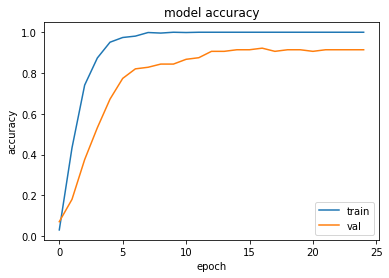

In [29]:
fig_acc = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [30]:
model_2.evaluate(test_set)

193/193 [==============================] - 9s 46ms/step - loss: 0.5619 - accuracy: 0.8745


[0.5618985891342163, 0.8744511008262634]

In [31]:
model=tf.keras.models.load_model('flowersModel.h5')
evalset,info = tfds.load(name='oxford_flowers102', split='test',as_supervised=True,with_info=True)
evalPipe=evalset.map(preprocess,num_parallel_calls=16).batch(128).prefetch(1)
for feats,lab in evalPipe.unbatch().batch(6000).take(1):
	probPreds=model.predict(feats)

top1err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=1))
top5err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=5))
top10err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=10))
print(top10err, top5err, top1err)

tf.Tensor(0.983, shape=(), dtype=float32) tf.Tensor(0.96683335, shape=(), dtype=float32) tf.Tensor(0.87416667, shape=(), dtype=float32)
